In [1]:
%pylab inline

from tqdm import tqdm_notebook as tqdm
from qsystem2_asm import *
from averager_program import AveragerProgram
from slab.instruments import InstrumentManager, Instrument
from rfsoc_instrument import *

import time


#qubit is on 229 ch 3
#readout is on 229 ch 2
#storage is on 229 ch 1
#JPA is on 229 ch 0

Populating the interactive namespace from numpy and matplotlib


Warning serial library import failed.
Warning could not load Chase AWG dll, check that dll located at 'C:\_Lib\python\slab\instruments\awg\chase\dax22000_lib_DLL32.dll'
Could not load InstrumentManagerWindow
Warning could not load LDA labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_atten.dll'
Warning could not load LMS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\vnx_fmsynth.dll'
Warning could not load LPS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_dps.dll'
Could not load labbrick


/usr/lib/python3/dist-packages/IPython/qt.py:13: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  "You should import from qtconsole instead.", ShimWarning)


In [2]:
# Load bitstream with custom overlay
im=InstrumentManager(ns_address='192.168.14.1')
rLO=im['RF8']
#rLO.set_frequency(8.1516e9)
rLO.set_frequency(6.9516e9)
soc_inst=RFSocInstrument(name="soc184")

# Resonator Spectroscopy

In [10]:
class ResonatorSpectroscopyProgram(AveragerProgram):
    def __init__(self,cfg):
        AveragerProgram.__init__(self,cfg)

    def initialize(self):
        cfg=self.cfg   
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2
        self.cfg["adc_freqs"]=[self.adcfreq(self.cfg["frequency"])]*2
        
        self.add_pulse(ch=self.cfg["res_ch"], name="measure",style="const", length=self.cfg["readout_length"])
        freq=self.freq2reg(cfg["frequency"])
        
        self.pulse(ch=cfg["res_ch"], name="measure", freq=freq, phase=0, gain=cfg["res_gain"],  length=self.cfg['readout_length'] , t= 0, play=False)
        self.synci(200)
    
    def body(self):
        self.trigger_adc(adc1=1, adc2=1)
        self.pulse(ch=self.cfg["res_ch"], play=True)
        self.sync_all()
        self.delay(self.us2cycles(self.cfg["relax_delay"]))        

{'start': 1090.03125, 'step': 0.09375, 'expts': 100}


(-1, 50)

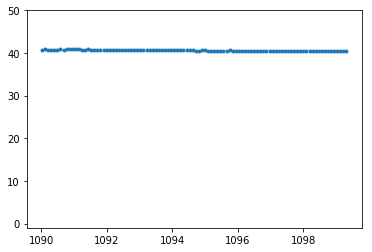

In [28]:
config={"res_ch":1,"reps":1000,
        "readout_length":1000, "res_gain":15000, "res_phase":0,
        "relax_delay":10, "frequency": 1100
       }

rspec=ResonatorSpectroscopyProgram(config)
sweep_cfg={"start":rspec.adcfreq(1090), "step":rspec.adcfreq(.1), "expts":100}
print (sweep_cfg)

fpts=sweep_cfg["start"]+sweep_cfg["step"]*arange(sweep_cfg["expts"])

results=[]
for f in tqdm(fpts):
    config["frequency"]=f

    rspec=ResonatorSpectroscopyProgram(config)
    results.append(soc_inst.acquire(rspec, load_pulses=True))
    
results=np.transpose(results)

plot(fpts,results[5],'.')
ylim(-1, 50)